# Machine Learning Mutliclassifier for Twitter Marketing Message Types
**by Alex Gamboa, Vito Perez, and Gerard Tieng**

For this project, we were able to access two years of native Twitter Analytics data from a Los Angeles-based marketing and networking expert with more than 10,000 followers. After understanding their brand, we manually sorted each tweet in the set and labeled each as one of their 4 core message types.
- 1: Business & Promotionm
- 2: Spotlights & Shoutouts
- 3: Positivity & Wellness
- 4: Replies

In social media marketing, the person responsible for publishing a tweet may apply a metatag to the post in order to analyze the effectivenesss of the brand message as part of an overall campaign or similar types of messages in the past. In absence of such a person in our this case, we shall see if supervised machine learning plus Natural Langauge Processing libraries can correctly classify the text of any given tweet from their account into one of the four types.

## Data Cleansing

Before we begin to train our model, we'll need to clean the data. We'll import the Pandas library to load in our data and inspect it.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
df = pd.read_csv("resources/goldie_master_cleaned_0314.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10186 entries, 0 to 10185
Data columns (total 19 columns):
Unnamed: 0             10186 non-null int64
Tweet permalink        10186 non-null object
Tweet text             10186 non-null object
Type                   10184 non-null float64
time                   10186 non-null object
impressions            10186 non-null float64
engagements            10186 non-null float64
engagement rate        10185 non-null float64
retweets               10186 non-null float64
replies                10186 non-null float64
likes                  10186 non-null float64
user profile clicks    10186 non-null float64
url clicks             10186 non-null float64
hashtag clicks         10186 non-null float64
detail expands         10186 non-null float64
permalink clicks       10186 non-null float64
follows                10186 non-null int64
media views            10186 non-null int64
media engagements      10186 non-null int64
dtypes: float64(12), int64(4

Well make sure to drop any null values before working with the set (2 rows), then we'll slice out the only relevant columns for machine learning ("Tweet text" & "Type"). We'll rename these columns for simplicity and then reset the index for order.

In [2]:
df= df.dropna()
df = df[["Tweet text", "Type"]]
df = df.rename(columns={"Tweet text":"text", "Type":"class"})
df = df.reset_index(drop=True)
df.head()

,text,class
0,HAPPY NEW YEAR 🎉\nMay all your dreams come tru...,2.0
1,“I've learned that you shouldn't go through li...,3.0
2,This 👇 https://t.co/4niBsvseUQ,1.0
3,Where should I go next? #travel https://t.co/D...,3.0
4,DONE with first day of #work back. Current fee...,2.0


Upon this initial inspection, we see that there are many strings in the dataset that would be considered non-words and symbols (like emojis, hashtags, and links) and scrambled in future Tokenization and Stemming steps. We'll use regular expression to remove these strings. Below, we'll loop through the "text" columns to match and eliminate raw [url strings](http://www.google.com) , #hashtags and @mentions.

In [3]:
#compiles list of non-emoji symbols
non_emoji = [letter for letter in "\\\'\"1234567890abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ`~!@#$%^&*()-_=+[{]}|,<.>/?"]


import re
for i in range(df.shape[0]):
    
    dirty = df.iloc[i,0]
    dirty = re.sub("https\S+", "", dirty) #links
    dirty = re.sub("@\S+", "", dirty) #@mentions
    dirty = re.sub("&amp", "", dirty) #ampersands
    dirty = re.sub("\n", "", dirty) #newline
    clean = re.sub("#", "", dirty) #hashtags
    
    sentence = clean.split()
    for words in sentence:
        for letters in words:
            if letters not in non_emoji:
                clean = clean.replace(letters, "") #emojis
    
    df.iloc[i,0] = clean
    
df.head()

,text,class
0,HAPPY NEW YEAR May all your dreams come true i...,2.0
1,I've learned that you shouldn't go through lif...,3.0
2,This,1.0
3,Where should I go next? travel,3.0
4,DONE with first day of work back. Current feel...,2.0


## Machine Learning Pre-Processing

Next, we will be performing 1 of 2 final string transformations before training the model. In the following code, the PorterStemmer() function will be used to consolidate related words into root strings (e.g. happy, happiness = "happi") for a more accurate and streamlined representation in the word vector we'll generate later. Meanwhile, Stopwords is a common filter for non-essential words (i.e. "the" and "a").

With the following code, we'll split apart each of the tweets into individual words and stem each word before assembling the full tweet back together as a "cleaned" string.

In [4]:
#Natural Language Toolkit for NLP processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

stemmer = PorterStemmer()
words = stopwords.words("english")

def machine_ready(tweet):
    tweet = tweet.split()
    ready = []
    for elements in tweet:
        if elements not in words:
            elements = re.sub("[^a-zA-Z]", "", elements) #remove punctuation
            elements = stemmer.stem(elements) #stem words
            elements = elements.lower() #lowercase words
            ready.append(elements)
    return " ".join(ready)

df["cleaned"] = df["text"].apply(machine_ready)
df.head()

,text,class,cleaned
0,HAPPY NEW YEAR May all your dreams come true i...,2.0,happi new year may dream come true
1,I've learned that you shouldn't go through lif...,3.0,ive learn go life catcher mitt hand need abl t...
2,This,1.0,thi
3,Where should I go next? travel,3.0,where i go next travel
4,DONE with first day of work back. Current feel...,2.0,done first day work back current feel


In [5]:
#standard data libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#scikit-learn for Machine Learning algorithms

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

#pickle for algorithm export
import pickle

Finally, we'll use sklearn's Vectorizor to convert the contents of each tweet as an array notating the appearances of each word for use in machine learning.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english")
features = vectorizer.fit_transform(df['cleaned']).toarray()
features.shape

(10183, 8596)

## Machine Learning

Before training our model, the dataset will need to be vectorized as an array in order for computers to process language. Each unique word (in our case 8500+ of them) will be represented in its own position in the vector, the combination of which forms the entire tweet.

In [7]:
from sklearn.model_selection import train_test_split

X = features
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

For this project, we'll be comparing the use 4 different model algorithms to see which is best used to predict our project's 4 core message types. Using Pipeline will help us keep track of the models used along with the Kbest priority feature selector.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


lr = Pipeline([('chi',  SelectKBest(chi2, k=20)),
                     ('clf', LogisticRegression())])
rfc = Pipeline([('chi',  SelectKBest(chi2, k=20)),
                     ('clf', RandomForestClassifier())])
mnb = Pipeline([('chi',  SelectKBest(chi2, k=20)),
                     ('clf', MultinomialNB())])
lsvc = Pipeline([('chi',  SelectKBest(chi2, k=20)),
                     ('clf', LinearSVC())])


models = [lr, rfc, mnb, lsvc]
model_name = ["lr", "rfc", "mnb", "lsvc"]

model_train_score= {}
model_test_score= {}


for i in range(len(models)):
    model_fit = models[i].fit(X_train, y_train)
    
    train_score = model_fit.score(X_train, y_train)
    test_score = model_fit.score(X_test, y_test)
    
    model_train_score[model_name[i]] = round(train_score, 2)
    model_test_score[model_name[i]] = round(test_score, 2)

print("train scores")
print(model_train_score)
print("test scores")
print(model_test_score)

train scores
{'lr': 0.51, 'rfc': 0.62, 'mnb': 0.49, 'lsvc': 0.52}
test scores
{'lr': 0.53, 'rfc': 0.52, 'mnb': 0.51, 'lsvc': 0.53}


Random Forest Classifier appears to be the most accurate of all the models, though the classifier is only right about half the time in any scenario. Interestingly, when looking at the distribution of the values, about half of the tweets in the dataset belong in the Class 4 category. In the next section, we'll export the algorithm and validate our findings.

Text(0,0.5,'Count')

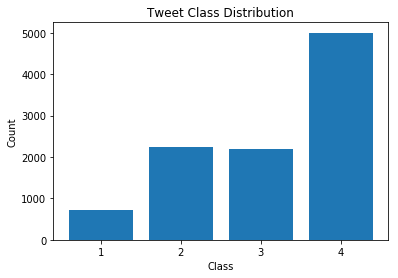

In [9]:
plt.bar([1,2,3,4], df["class"].value_counts().sort_index())
plt.title("Tweet Class Distribution")
plt.xlabel("Class")
plt.xticks([1,2,3,4])
plt.ylabel("Count")

## Exporting the Algorithm for Use & Verification

With the pickle library, Python allows us to export the algorithm to a file. In this instance, we'll choose our most accurate one to export.

In [10]:
with open('rfc.pickle', 'wb') as f:
    pickle.dump(rfc, f)

We'll program a custom classify function to accept the tweet string, filter it through the classifer, and return the result.

In [11]:
pickle_load = open('rfc.pickle', 'rb')
clf = pickle.load(pickle_load)

def classify(string):
    non_emoji = [letter for letter in "\\\'\"1234567890abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ`~!@#$%^&*()-_=+[{]}|,<.>/?"]
    for i in string:
        dirty = str(string)
        dirty = re.sub("https\S+", "", dirty) #links
        dirty = re.sub("@\S+", "", dirty) #@mentions
        dirty = re.sub("&amp", "", dirty) #ampersands
        dirty = re.sub("\n", "", dirty) #newline
        clean = re.sub("#", "", dirty) #hashtags
    
        sentence = clean.split()
        for words in sentence:
            for letters in words:
                if letters not in non_emoji:
                    clean = clean.replace(letters, "") #emojis
                    
        tweet = clean.split()
        ready = []
        
        for elements in tweet:
            if elements not in words:
                elements = re.sub("[^a-zA-Z]", "", elements) #remove punctuation
                elements = stemmer.stem(elements) #stem words
                elements = elements.lower() #lowercase words
                ready.append(elements)
        tweet = " ".join(ready)

        pred = clf.predict(vectorizer.transform([tweet]))[0]
        return pred

We'll use 100 tweets from March which has never before been used in testing or training to validate the data.

In [12]:
march = pd.read_csv("resources/goldie_march.csv")

In [20]:
march = march[["Tweet text", "Type"]]
march = march.rename(columns={"Tweet text": "text", "Type": "class"})

In [22]:
march["predictions"] = march["text"].apply(classify)

According to the bar plots below, the classifier isn't near the 50% projected accuracy of our algorithm for this set.

(0, 100)

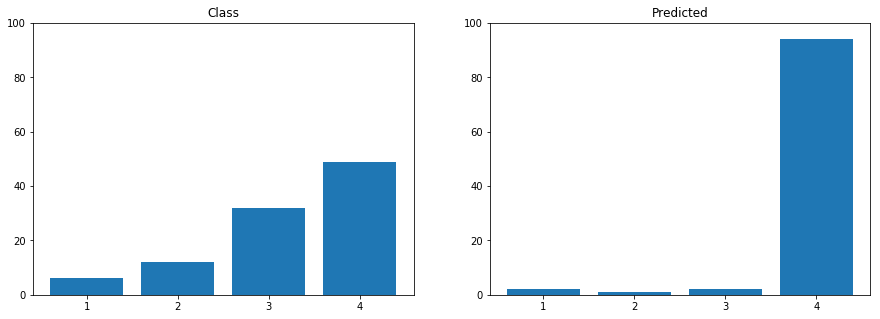

In [45]:
#actual for March Data
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar([1,2,3,4], march["class"].value_counts().sort_index())
plt.title("Class")
plt.xticks([1,2,3,4])
plt.ylim(0,100)

#predicted for March data
plt.subplot(1,2,2)
plt.bar([1,2,3,4], march["predictions"].value_counts().sort_index())
plt.title("Predicted")
plt.xticks([1,2,3,4])
plt.ylim(0,100)

We have a theory that the unexpected topical shift to COVID-19 during March 2020 for our subject may be affecting the classifier from correctly identifying the correct category.

## Considering Other Models

In further research and experimentation, Latent Dirichlet Allocation (LDA) had been identified as a potential solution for the classification our data via unsuperivised topic modeling. The following code from this [source](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) displays information including popular terms and the relationships of such terms to others to form patterns in potential topics.

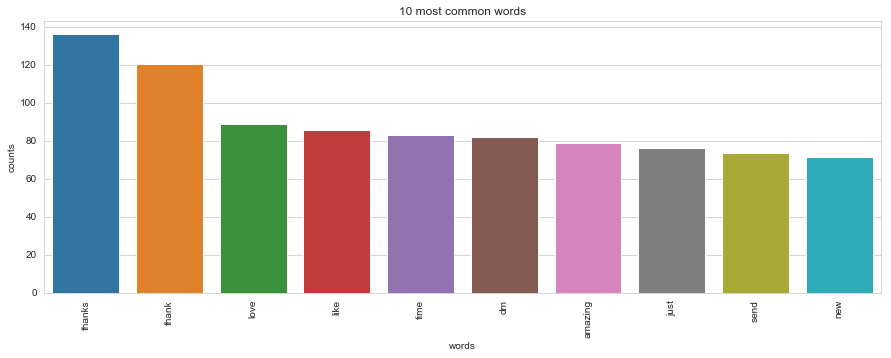

In [50]:
import seaborn as sns
sns.set_style('whitegrid')
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 5))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2})
    sns.barplot(x_pos, counts)
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Fit and transform the processed titles
count_data = vectorizer.fit_transform(df['text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, vectorizer)

Unsupervised training has naturally segmented a few popular topics from the dataset including themes like LinkedIn, DnD & Adobe (Class 1), gratitude content (Class 2), but no easily visible tweets from Class 3 (positivity) & 4 (replies).

In [53]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
dm send pls congrats adobeinsiders life shoot video awnewyork heart

Topic #1:
millennialtalk got winniesun today love just awesome year think linkedin

Topic #2:
adobesummit yep right woo happy ooo brand bday people john

Topic #3:
thank amazing omg hahaha cute love let lol sis people

Topic #4:
hi time wait say love friends ok thing feel new

Topic #5:
good did real just going ll love learn make like

Topic #6:
yes followed true sweet worth kerry time value based listen

Topic #7:
fun adobemax like nasasocial hello lets new sounds hahahaha just

Topic #8:
lovely wow youre content know soon oh thank hope think

Topic #9:
thanks sharing aww yay thank proud mention yup article new


## Conclusion

While not an impossible task, classifying tweets appears to be a difficult one. Unlike a traditional string expression, such as e-mail and product reviews, conversations on the Twitter platform can be very unique and varied (e.g. the contextual use of images/gifs/emoji, codeshifting between one-to-one and one-to-many type of conversations, and the infinite combinations of topics that could take place on any given day). We anticipate a more accurate model could be created with more training data and more disciplined style of writing under the identified classes.